In [1]:
# OLD EVALUATION FILE - NOT USED! 

import os 
import yaml
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn-v0_8')
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

DATASETS_1 = ['dataset-room1_512_16', 'dataset-room1_512_16_20', 'dataset-room1_512_16_8', 'dataset-room1_512_16_7', 'dataset-room1_512_16_6', 'dataset-room1_512_16_5', 'dataset-room1_512_16_4', 'dataset-room1_512_16_3', 'dataset-room1_512_16_2-5', 'dataset-room1_512_16_2']  #'dataset-room1_512_16_2'
DATASETS_2 = ['dataset-room2_512_16', 'dataset-room2_512_16_20', 'dataset-room2_512_16_8', 'dataset-room2_512_16_7', 'dataset-room2_512_16_6', 'dataset-room2_512_16_5', 'dataset-room2_512_16_4', 'dataset-room2_512_16_3', 'dataset-room2_512_16_2-5', 'dataset-room2_512_16_2']

#path_to_results = '../runs'
path_to_results = '/home/cm2113/workspace/results'
x = [0.0, 1.0/20.0, 1.0/8.0, 1./7., 1./6., 1./5., 1./4., 1./3., 1./2.5, 1./2.]


In [2]:
def extract_results(data_folder):
    runs = sorted(os.listdir(data_folder))
    sorted_runs = sorted(runs, key=lambda x: int(x.split('_')[1]))
    scale_error, trans_error = [], []
    for run in sorted_runs: 
        path = f'{data_folder}/{run}/saved_results/traj_est/absolute_err_statistics_sim3_-1.yaml'
        with open(path) as f:
            data = yaml.load(f, Loader=yaml.loader.FullLoader)
            scale_error.append(data["scale"]['rmse'])
            trans_error.append(data['trans']['rmse'])
            #print(f"run: {run}: trans rmse {data['trans']['rmse']}")
    return scale_error, trans_error

def plot_data_fill(mean, std, x_vec, imu):
    upper_limit = np.array(mean) + np.array(std) 
    lower_limit = np.array(mean) - np.array(std)
    plt.title(f'Translational error, with 10 itterations for each sequence')
    plt.plot(x_vec, mean, label = f'mean - {imu}')
    plt.fill_between(x_vec, upper_limit, lower_limit, alpha=0.3, label='sd')
    plt.xlabel('Time factor')
    plt.ylabel('Translational RMSE')

# at, only returning translational error statistics 
def compute_results(imu, system, sub='', datasets=DATASETS_1): 
    res_s, res_t = {}, {}
    std_s, std_t = {}, {}
    runs = {}
    #datasets = [dataset] if dataset else DATASETS_1 
    
    for i in imu: 
        tot_s, tot_t = [], []
        s_s, s_t = [], []
        for dataset in datasets:
            data_folder = f'{path_to_results}/{dataset}/{system}/data{sub}/{i}'
            s, t = extract_results(data_folder)
            runs[dataset+i] = t
            tot_s.append(np.median(s))
            tot_t.append(np.median(t))
            s_s.append(np.std(s))
            s_t.append(np.std(t))
        res_s[i] = tot_s 
        res_t[i] = tot_t
        std_s[i] = s_s 
        std_t[i] = s_t
    return res_t, std_t, runs 


## ORB-SLAM Analysis - DATASETS_1 

In [5]:
system = 'orb_slam'
imu = ['withimu', 'withoutimu']

comp_orb_res_t, comp_orb_std_t, comp_orb_tot_t = compute_results(imu=imu, system=system, sub='/compensated10') 
noncomp_orb_res_t, noncomp_orb_std_t, noncomp_orb_tot_t = compute_results(imu=imu, system=system, sub='/noncompensated10') 
new_gt_t, new_gt_std_t, new_gt_tot_t = compute_results(imu=imu, system=system, sub='/noncompensated10_other_gt')

0.07212765985702665


[0.07155191822895914,
 0.07214822158221325,
 0.07163004970359306,
 0.07278607278681685,
 0.07194098373743466,
 0.0720334513415162,
 0.07223034472971912,
 0.07221568462082312,
 0.07243853176978687,
 0.07210709813184005]

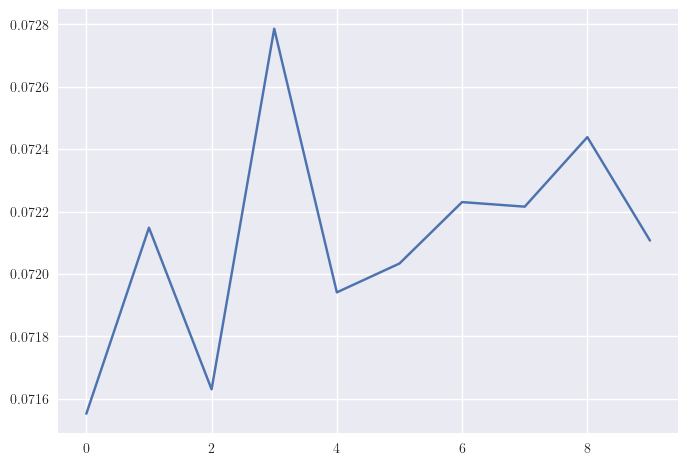

In [15]:
print(np.median(comp_orb_tot_t['dataset-room1_512_16withoutimu']))
plt.plot(comp_orb_tot_t['dataset-room1_512_16withoutimu'])
comp_orb_tot_t['dataset-room1_512_16withoutimu']

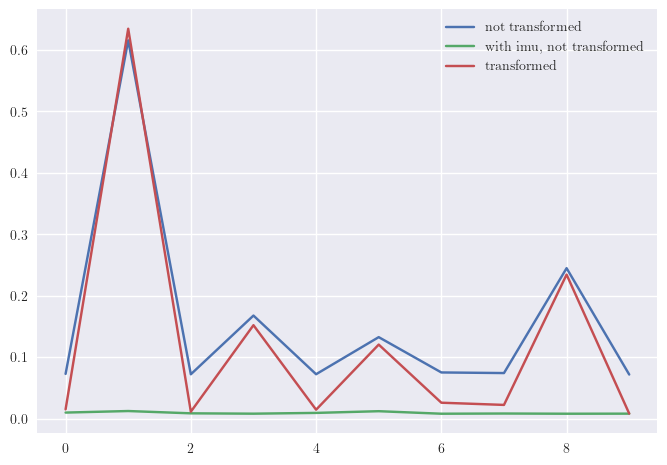

0.03983248295562823


In [7]:

plt.figure()
plt.plot(noncomp_orb_tot_t['dataset-room1_512_16withoutimu'], label='not transformed')
plt.plot(noncomp_orb_tot_t['dataset-room1_512_16withimu'], label='with imu, not transformed')
plt.plot(new_gt_tot_t['dataset-room1_512_16withoutimu'], label='transformed')
plt.legend()
plt.show()
p = [abs(i-j) for (i,j) in zip (noncomp_orb_tot_t['dataset-room1_512_16withoutimu'],new_gt_tot_t['dataset-room1_512_16withoutimu'])]
print(np.mean(p))

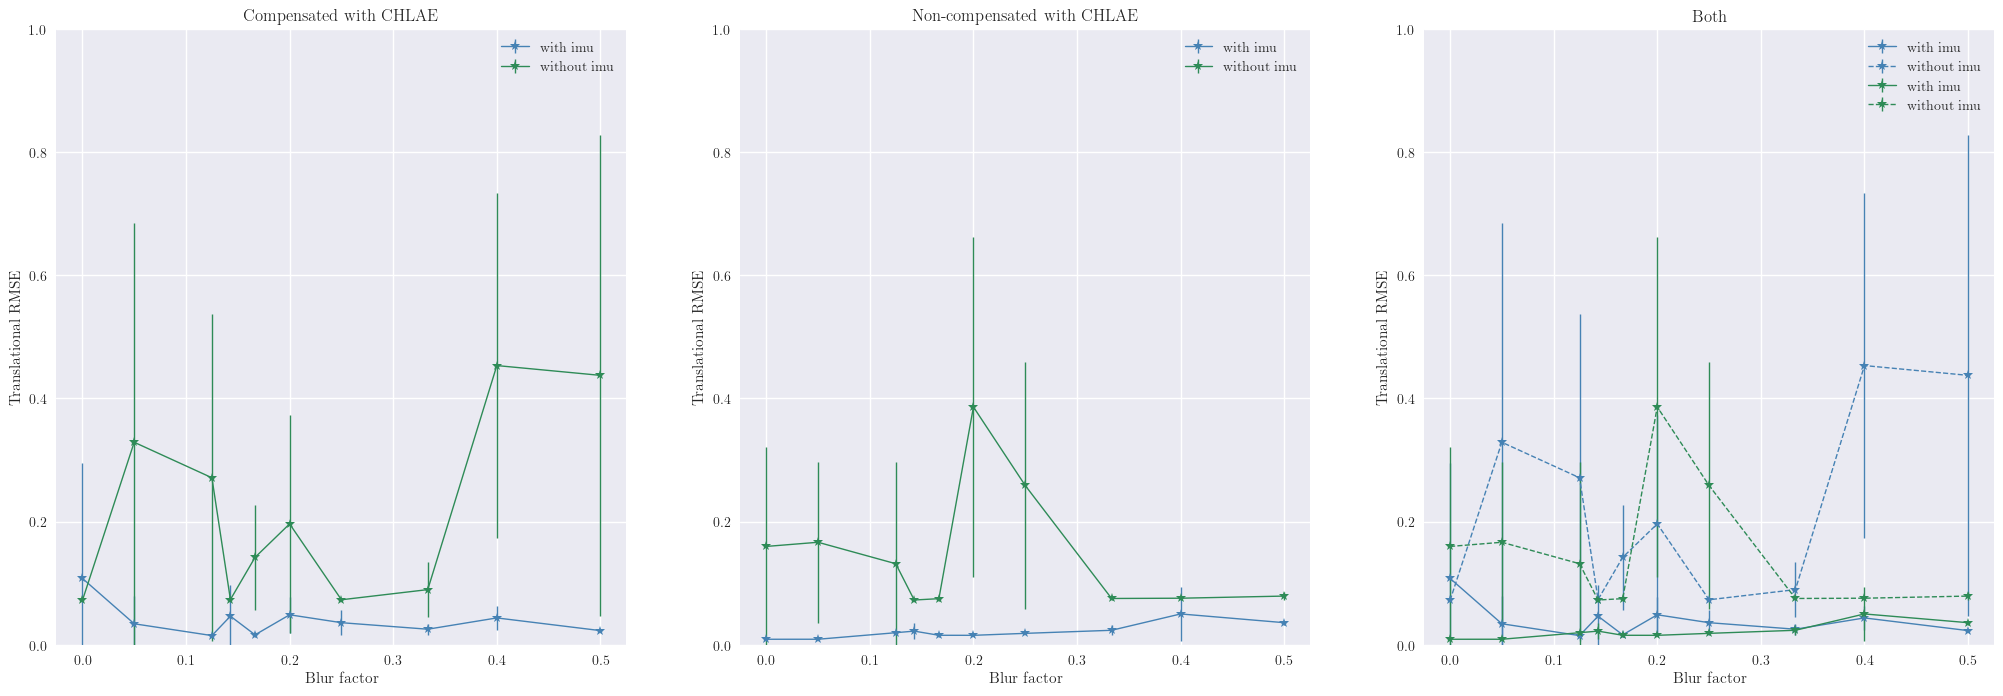

Mean compensated and with imu: 0.039773939085945
Mean not compensated and with imu: 0.022035395290961282
------------------------------------------------------------
Mean compensated and without imu: 0.2138613372318819
Mean not compensated and without imu: 0.14815392284758236


In [9]:
fig, ax = plt.subplots(1,3, figsize=(25,8))

ax[0].set_title('Compensated with CHLAE')
ax[0].errorbar(x, comp_orb_res_t['withimu'], yerr=comp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[0].errorbar(x, comp_orb_res_t['withoutimu'], yerr=comp_orb_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
ax[0].set_ylim(0,1)
ax[0].set_ylabel('Translational RMSE')
ax[0].set_xlabel('Blur factor')
ax[0].legend() 

ax[1].set_title('Non-compensated with CHLAE')
ax[1].errorbar(x, noncomp_orb_res_t['withimu'], yerr=noncomp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[1].errorbar(x, noncomp_orb_res_t['withoutimu'], yerr=noncomp_orb_std_t['withoutimu'], fmt='-*', label='without imu', lw=1, color='seagreen')
ax[1].set_ylim(0,1)
ax[1].set_ylabel('Translational RMSE')
ax[1].set_xlabel('Blur factor')
ax[1].legend() 

ax[2].set_title('Both')
ax[2].errorbar(x, comp_orb_res_t['withimu'], yerr=comp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[2].errorbar(x, comp_orb_res_t['withoutimu'], yerr=comp_orb_std_t['withoutimu'], fmt='--*', label='without imu', lw=1, color='steelblue')
ax[2].errorbar(x, noncomp_orb_res_t['withimu'], yerr=noncomp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='seagreen')
ax[2].errorbar(x, noncomp_orb_res_t['withoutimu'], yerr=noncomp_orb_std_t['withoutimu'], fmt='--*', label='without imu', lw=1, color='seagreen')
ax[2].set_ylim(0,1)
ax[2].set_ylabel('Translational RMSE')
ax[2].set_xlabel('Blur factor')
ax[2].legend() 
plt.show()

print(f"Mean compensated and with imu: {np.mean(comp_orb_res_t['withimu'])}") 
print(f"Mean not compensated and with imu: {np.mean(noncomp_orb_res_t['withimu'])}") 
print("------------------------------------------------------------")
print(f"Mean compensated and without imu: {np.mean(comp_orb_res_t['withoutimu'])}") 
print(f"Mean not compensated and without imu: {np.mean(noncomp_orb_res_t['withoutimu'])}")

#### CLAHE compensated 

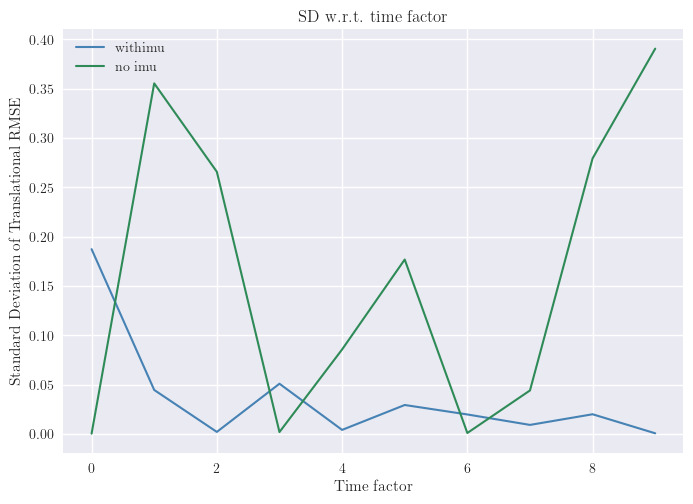

In [49]:
# Plot standard deviaton w.r.t time factor 
plt.figure()
plt.plot(comp_orb_std_t['withimu'], label='withimu', lw=1.5, color='steelblue')
plt.plot(comp_orb_std_t['withoutimu'], label='no imu', lw=1.5, color='seagreen')
plt.title('SD w.r.t. time factor')
plt.xlabel('Time factor')
plt.ylabel('Standard Deviation of Translational RMSE')
plt.legend()
plt.show()


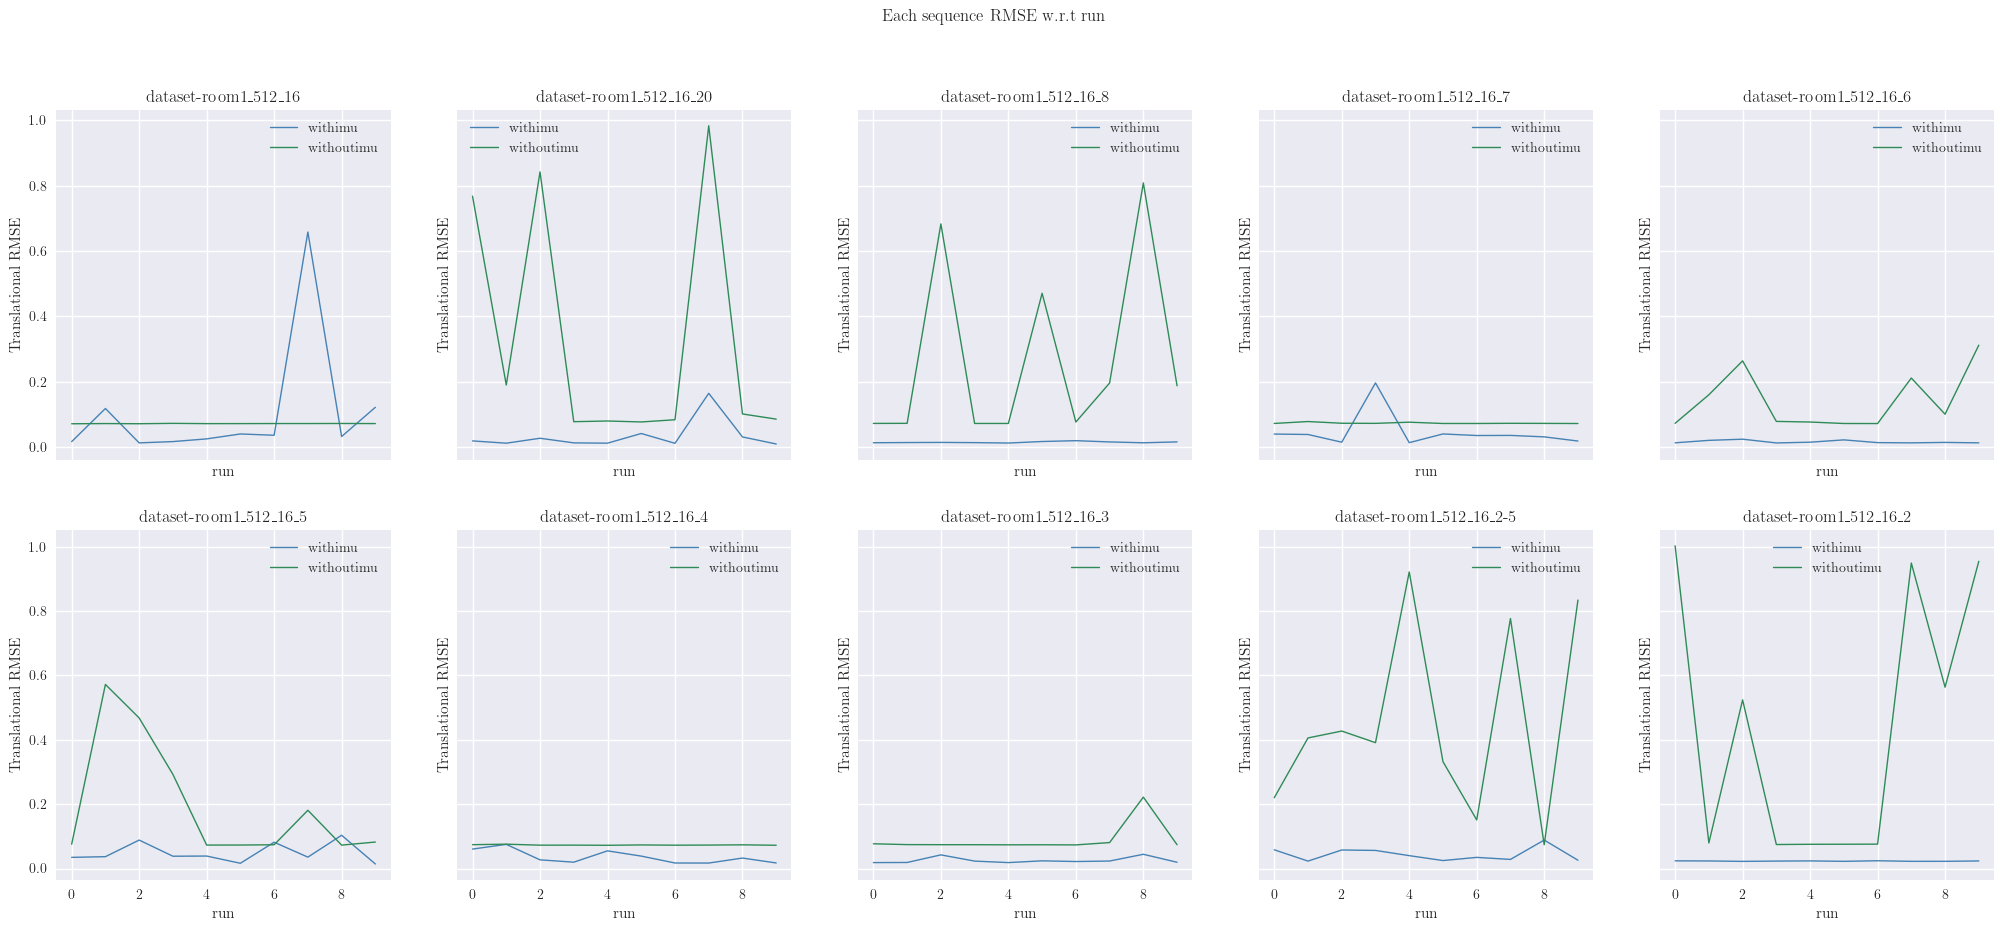

In [10]:
# plot the first sequence iterations in 'dataset-room1_512_16' - time factor 0 
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_1[count]}')
        axis.plot(comp_orb_tot_t[f'{DATASETS_1[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(comp_orb_tot_t[f'{DATASETS_1[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

#### Not CLAHE compensated - New and Old Groundtruth

In [1]:
plt.figure()
plt.plot(noncomp_orb_std_t['withimu'], label='withimu', ls='--', lw=1.5, color='steelblue')
plt.plot(noncomp_orb_std_t['withoutimu'], label='no imu', ls='--', lw=1.5, color='steelblue')
plt.plot(new_gt_std_t['withimu'], label='withimu - new gt', lw=1.5, color='seagreen')
plt.plot(new_gt_std_t['withoutimu'], label='no imu - new gt', lw=1.5, color='seagreen')
plt.title('SD w.r.t. time factor')
plt.xlabel('Blur factor')
plt.ylabel('Standard Deviation of Translational RMSE')
plt.legend()
plt.show()

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_1[count]}')
        axis.plot(noncomp_orb_tot_t[f'{DATASETS_1[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(noncomp_orb_tot_t[f'{DATASETS_1[count]}withoutimu'],  label='withoutimu', ls='-.', lw=1, color='steelblue')
        #axis.plot(noncomp_orb_tot_t_gt[f'{DATASETS_1[count]}withimu'],  label='withimu ', ls='--', lw=1, color='seagreen')
        axis.plot(new_gt_tot_t[f'{DATASETS_1[count]}withoutimu'],  label='withoutimu -- new gt', ls='--', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

plt.figure()
plt.errorbar(x, new_gt_t['withimu'], yerr=new_gt_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, new_gt_t['withoutimu'], yerr=new_gt_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Blur factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

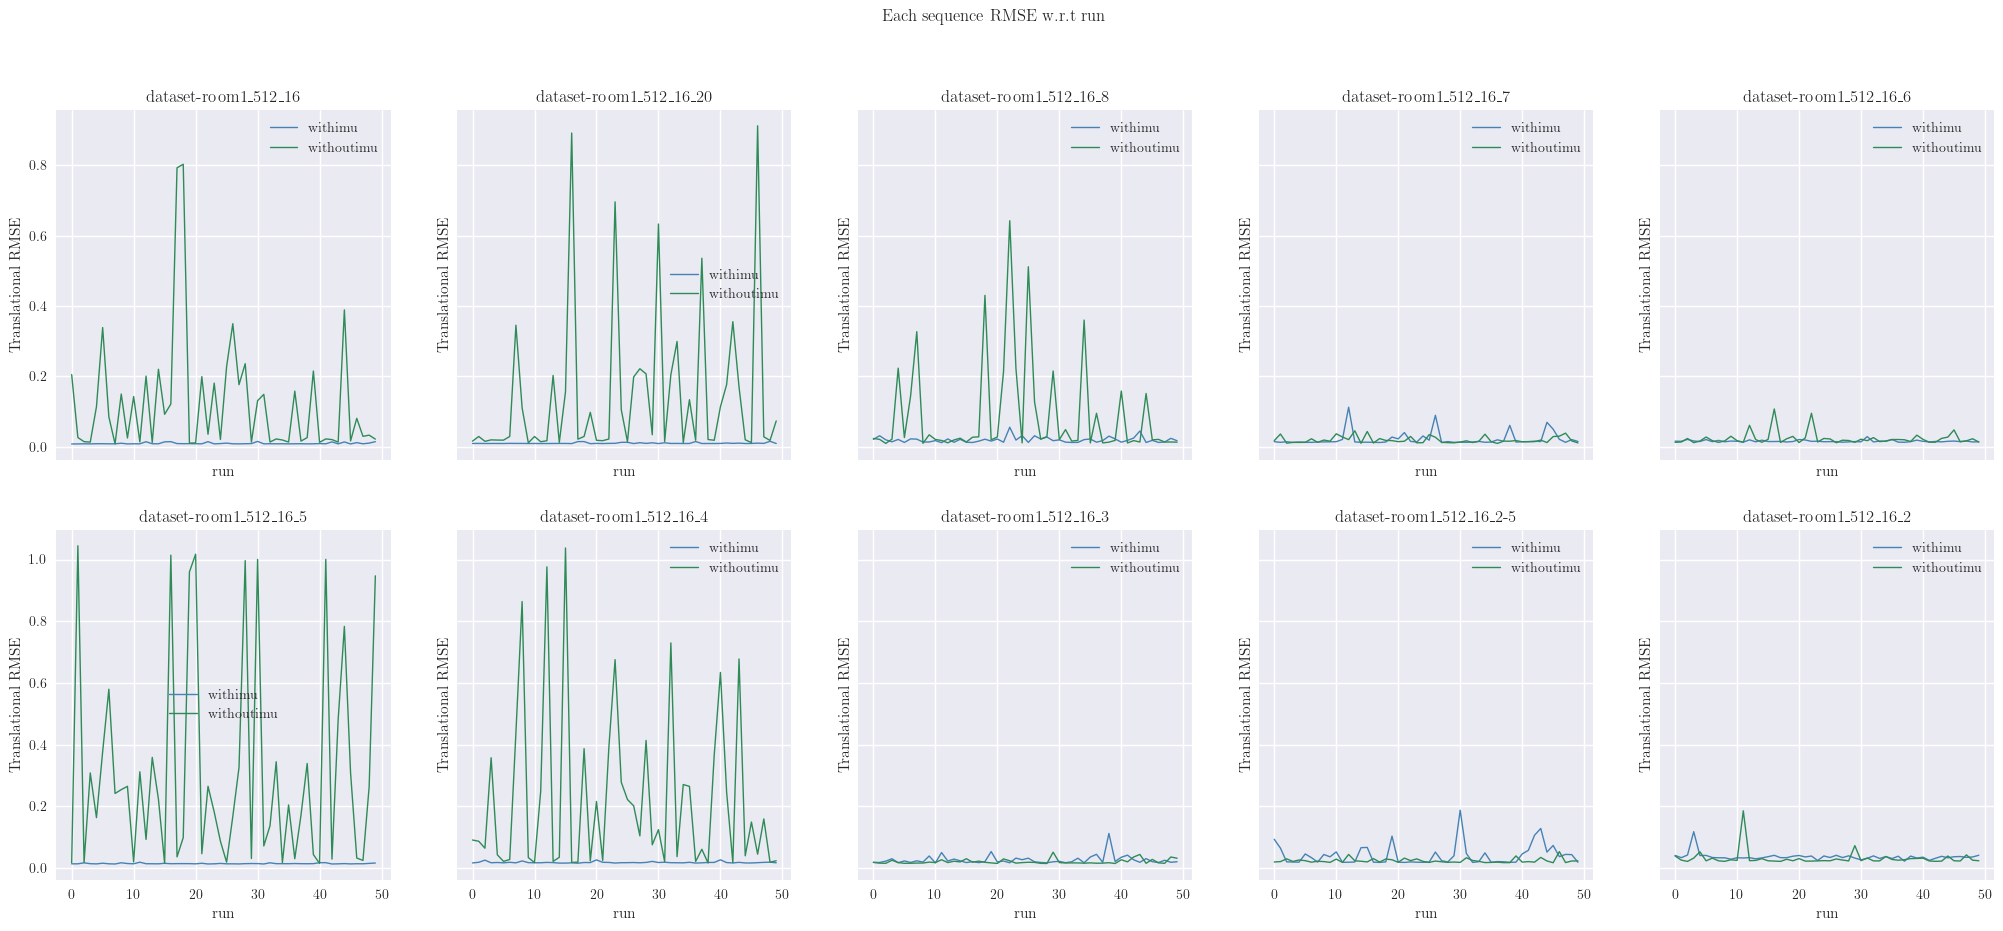

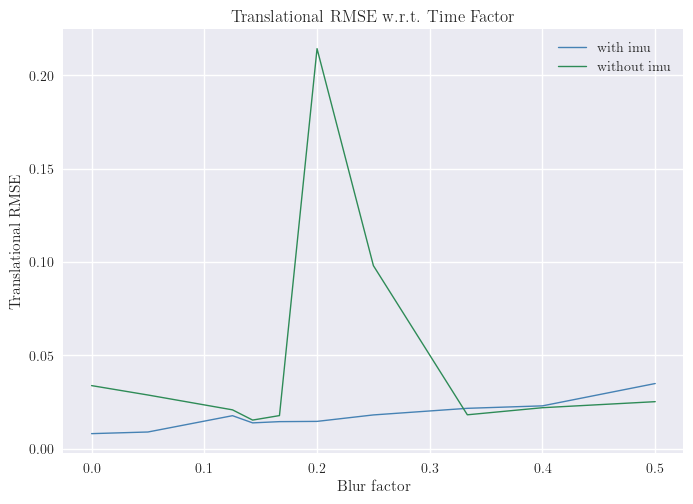

<Figure size 800x550 with 0 Axes>

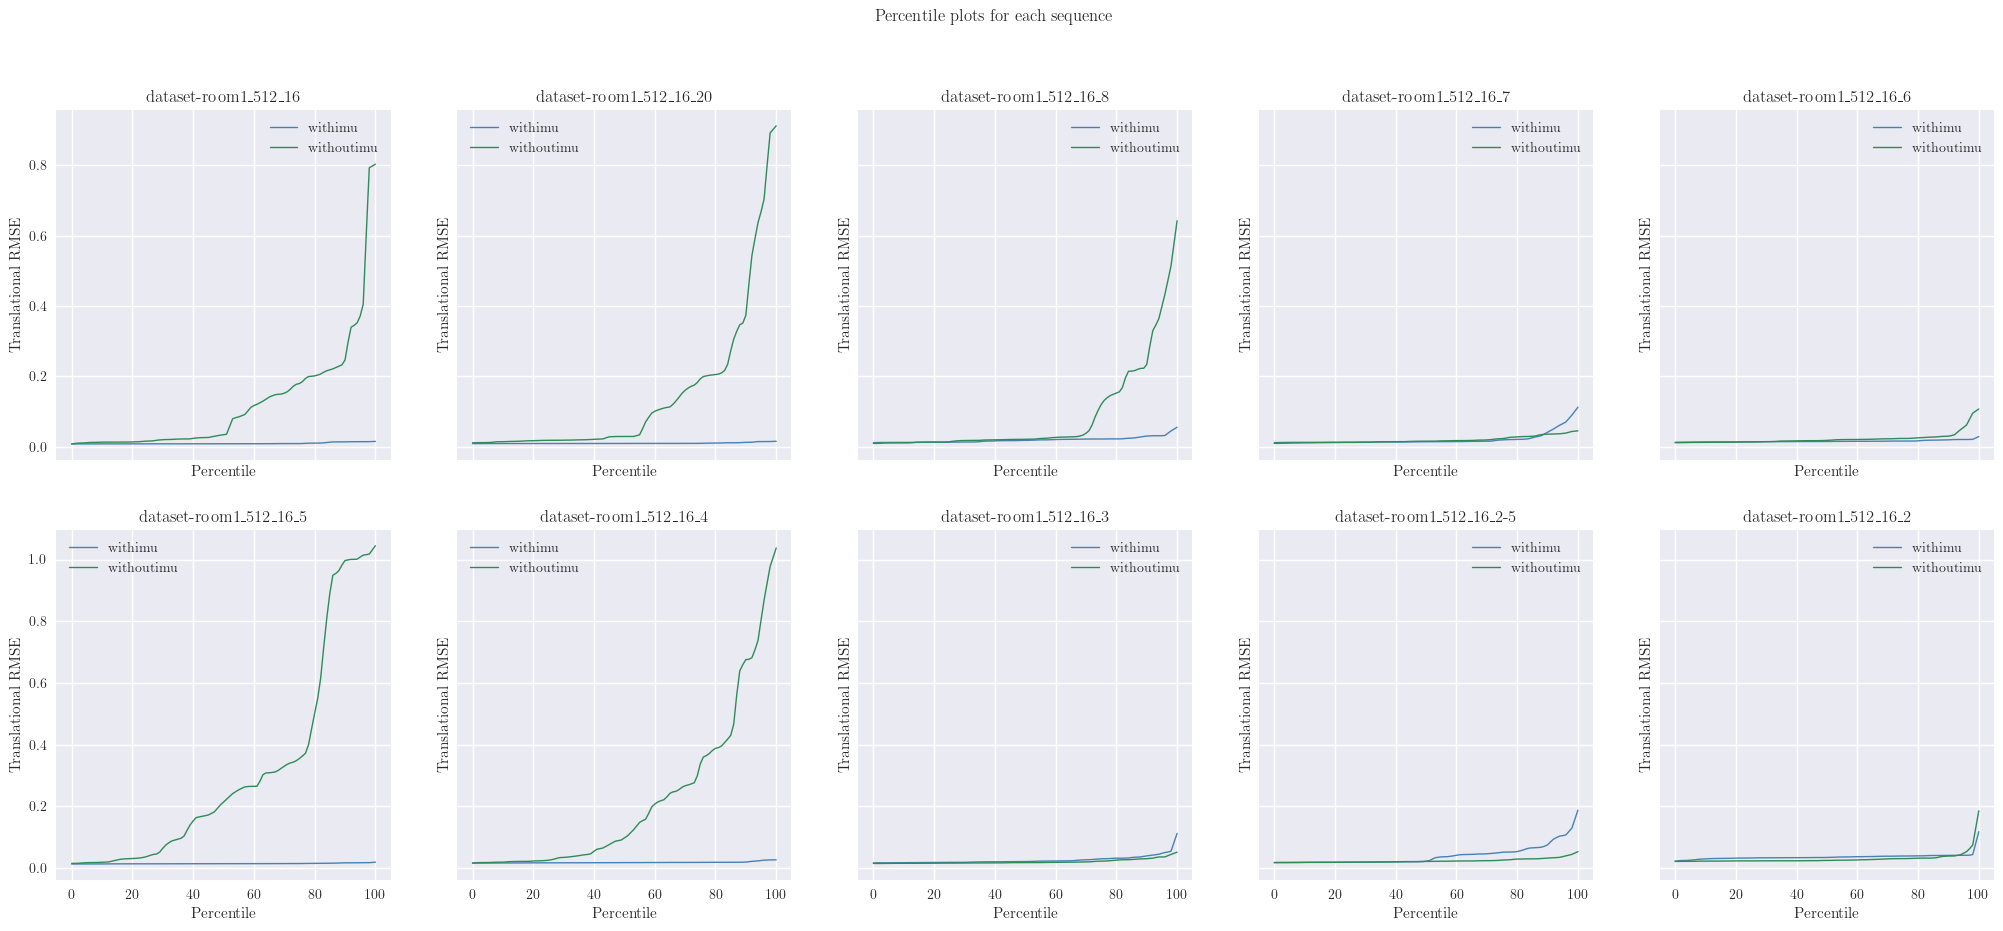

In [14]:
orb_res_t, orb_std_t, orb_tot_t = compute_results(imu=imu, system='orb_slam', sub='/multiple_runs50') 

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_1[count]}')
        axis.plot(orb_tot_t[f'{DATASETS_1[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(orb_tot_t[f'{DATASETS_1[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

plt.figure()
plt.plot(x, orb_res_t['withimu'], label='with imu', lw=1, color='steelblue')
plt.plot(x, orb_res_t['withoutimu'], label='without imu', lw=1, color='seagreen')
#plt.errorbar(x, orb_res_t['withimu'], yerr=orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
#plt.errorbar(x, orb_res_t['withoutimu'], yerr=orb_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Blur factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()
plt.savefig('median_orb.png')

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Percentile plots for each sequence')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_1[count]}')
        pctiles_wi = np.percentile(orb_tot_t[f'{DATASETS_1[count]}withimu'], np.arange(0, 101))
        pctiles_woi = np.percentile(orb_tot_t[f'{DATASETS_1[count]}withoutimu'], np.arange(0, 101))
        
        axis.plot(pctiles_wi,  label='withimu', lw=1, color='steelblue')
        axis.plot(pctiles_woi,  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('Percentile') 
        axis.set_ylabel('Translational RMSE')
        
        
        count += 1 
plt.savefig('orbslam_dataset1.png')

In [50]:
orb_res_t, orb_std_t, orb_tot_t = compute_results(imu=['withoutimu', 'withimu'], system='orb_slam', sub='/multiple_runs50', datasets=['dataset-room1_512_16']) 


['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49']


In [54]:
np.median(orb_tot_t['dataset-room1_512_16withoutimu'])

0.033871513481391266

## ORB-SLAM Analysis - DATASETS_2

Dataset for now contains - non-compensated and is evaluated on new ground truth

#### 10 iterations 

In [16]:
system = 'orb_slam'
imu = ['withimu', 'withoutimu']

orb_res_t_data2, comp_orb_std_t_data2, comp_orb_tot_t_data2 = compute_results(imu=imu, system=system, sub='/first10iterations', datasets=DATASETS_2) 

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']

In [34]:
x,y,z  = compute_results(imu=['withoutimu'], system='orb_slam', sub='/test_results', datasets=['dataset-room1_512_16']) 

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


In [37]:
z

{'dataset-room1_512_16withoutimu': [0.07192135859913419,
  0.15030412541143512,
  0.0717153445957286,
  0.07228085089793276,
  0.07155328440005371,
  0.07233269687117047,
  0.07399238035511423,
  0.07478463447738874,
  0.0724765178612188,
  0.07234402379804909]}

In [35]:
np.median(z['dataset-room1_512_16withoutimu'])

0.07233836033460977

In [39]:
x,y,z  = compute_results(imu=['withoutimu'], system='orb_slam', sub='/test_results', datasets=['dataset-room3_512_16'])
z 

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


{'dataset-room3_512_16withoutimu': [0.1025682936022739,
  0.12338870123007643,
  0.15769304758791988,
  0.680699778996371,
  0.12054856410274231,
  0.11248223414511944,
  1.1064490968721354,
  0.08678160033180471,
  0.10020158310383515,
  0.8645118329284716]}

In [28]:
t_data2, std_t_data2, tot_t_data2 = compute_results(imu=['withoutimu'], system='orb_slam', sub='/first10iterations_old_gt', datasets=['dataset-room2_512_16']) 
t_data2x, std_t_data2x, tot_t_data2x = compute_results(imu=['withoutimu'], system='orb_slam', sub='/first10iterations', datasets=['dataset-room2_512_16']) 

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


In [36]:
np.median(tot_t_data2['dataset-room2_512_16withoutimu'])

0.04878496627864744

In [29]:
tot_t_data2x

{'dataset-room2_512_16withoutimu': [0.009834495967050553,
  0.006752691427144857,
  0.006563869927129983,
  0.0075977600298685576,
  0.0074999683577355244,
  0.006544350021624223,
  0.00745478163567047,
  0.0070951215337332375,
  0.0066235084776603585,
  0.009121211441342656]}

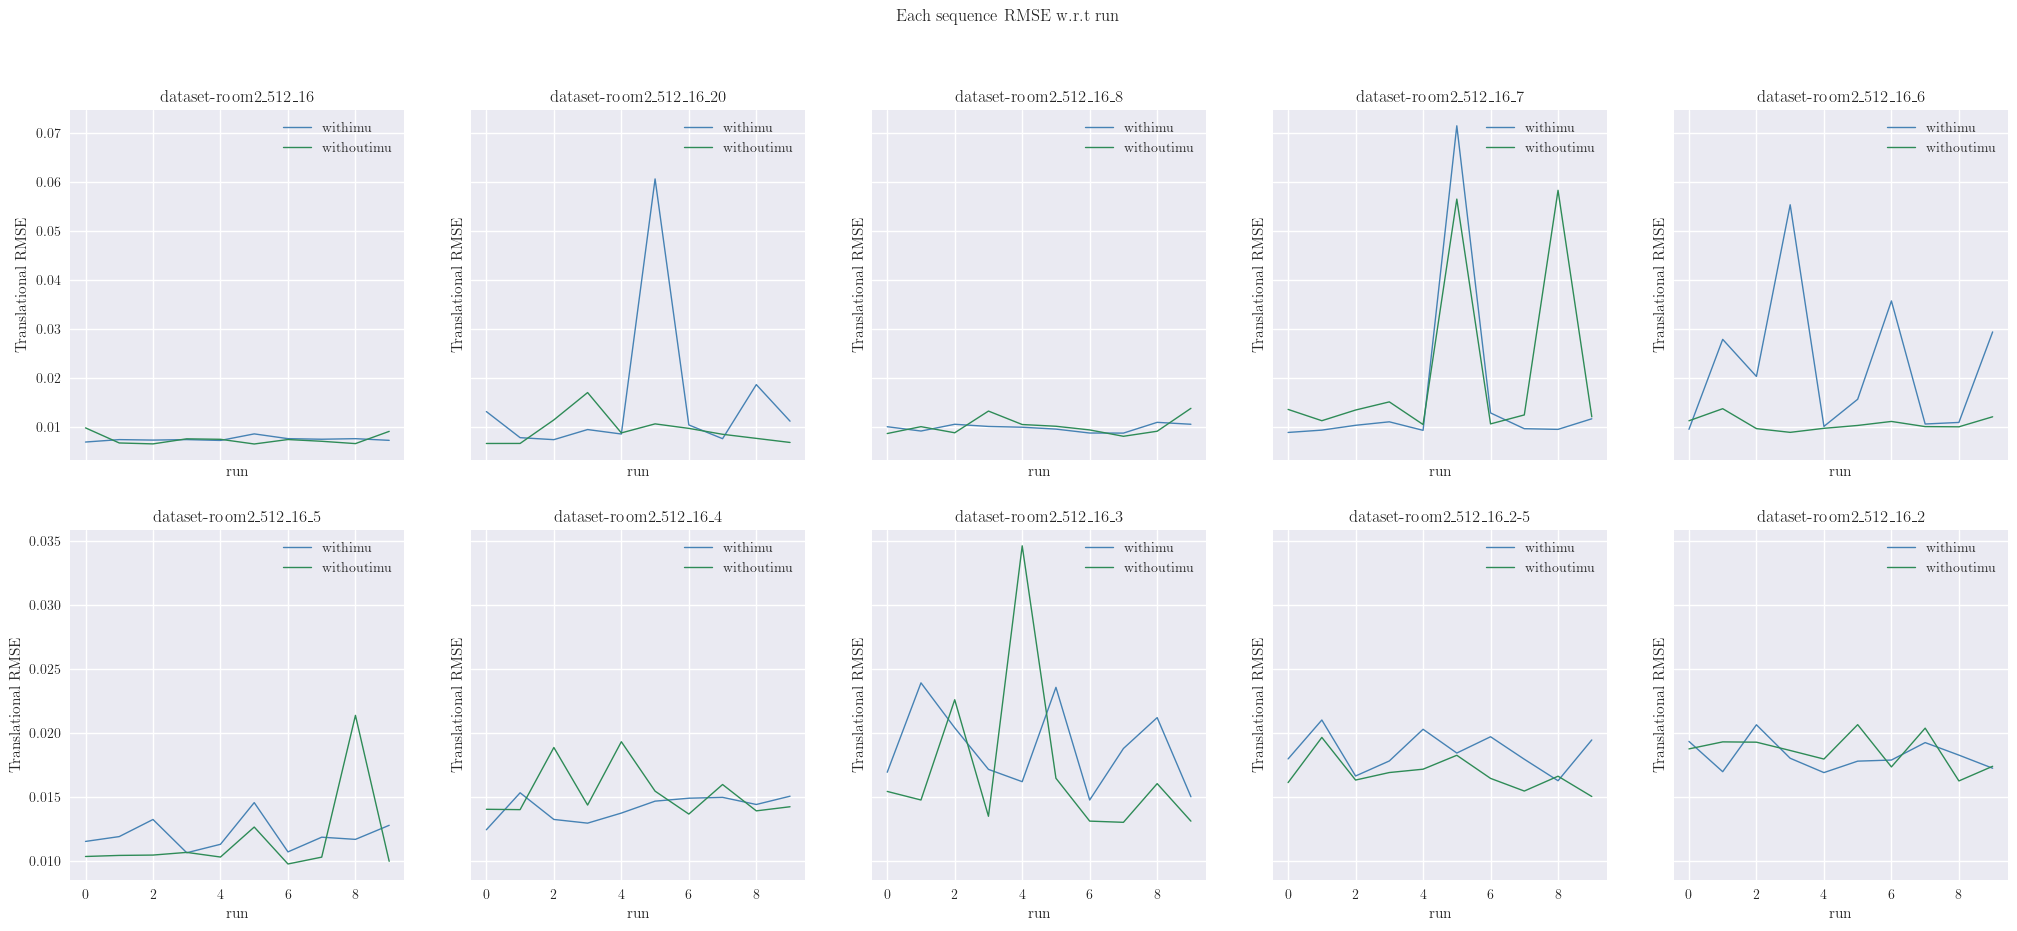

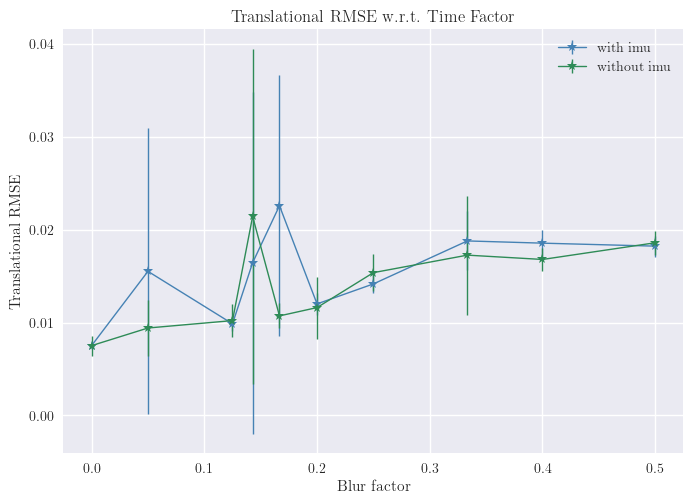

In [11]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_2[count]}')
        axis.plot(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

plt.figure()
plt.errorbar(x, orb_res_t_data2['withimu'], yerr=comp_orb_std_t_data2['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, orb_res_t_data2['withoutimu'], yerr=comp_orb_std_t_data2['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Blur factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()

#### 50 iterations - DATASET 2 

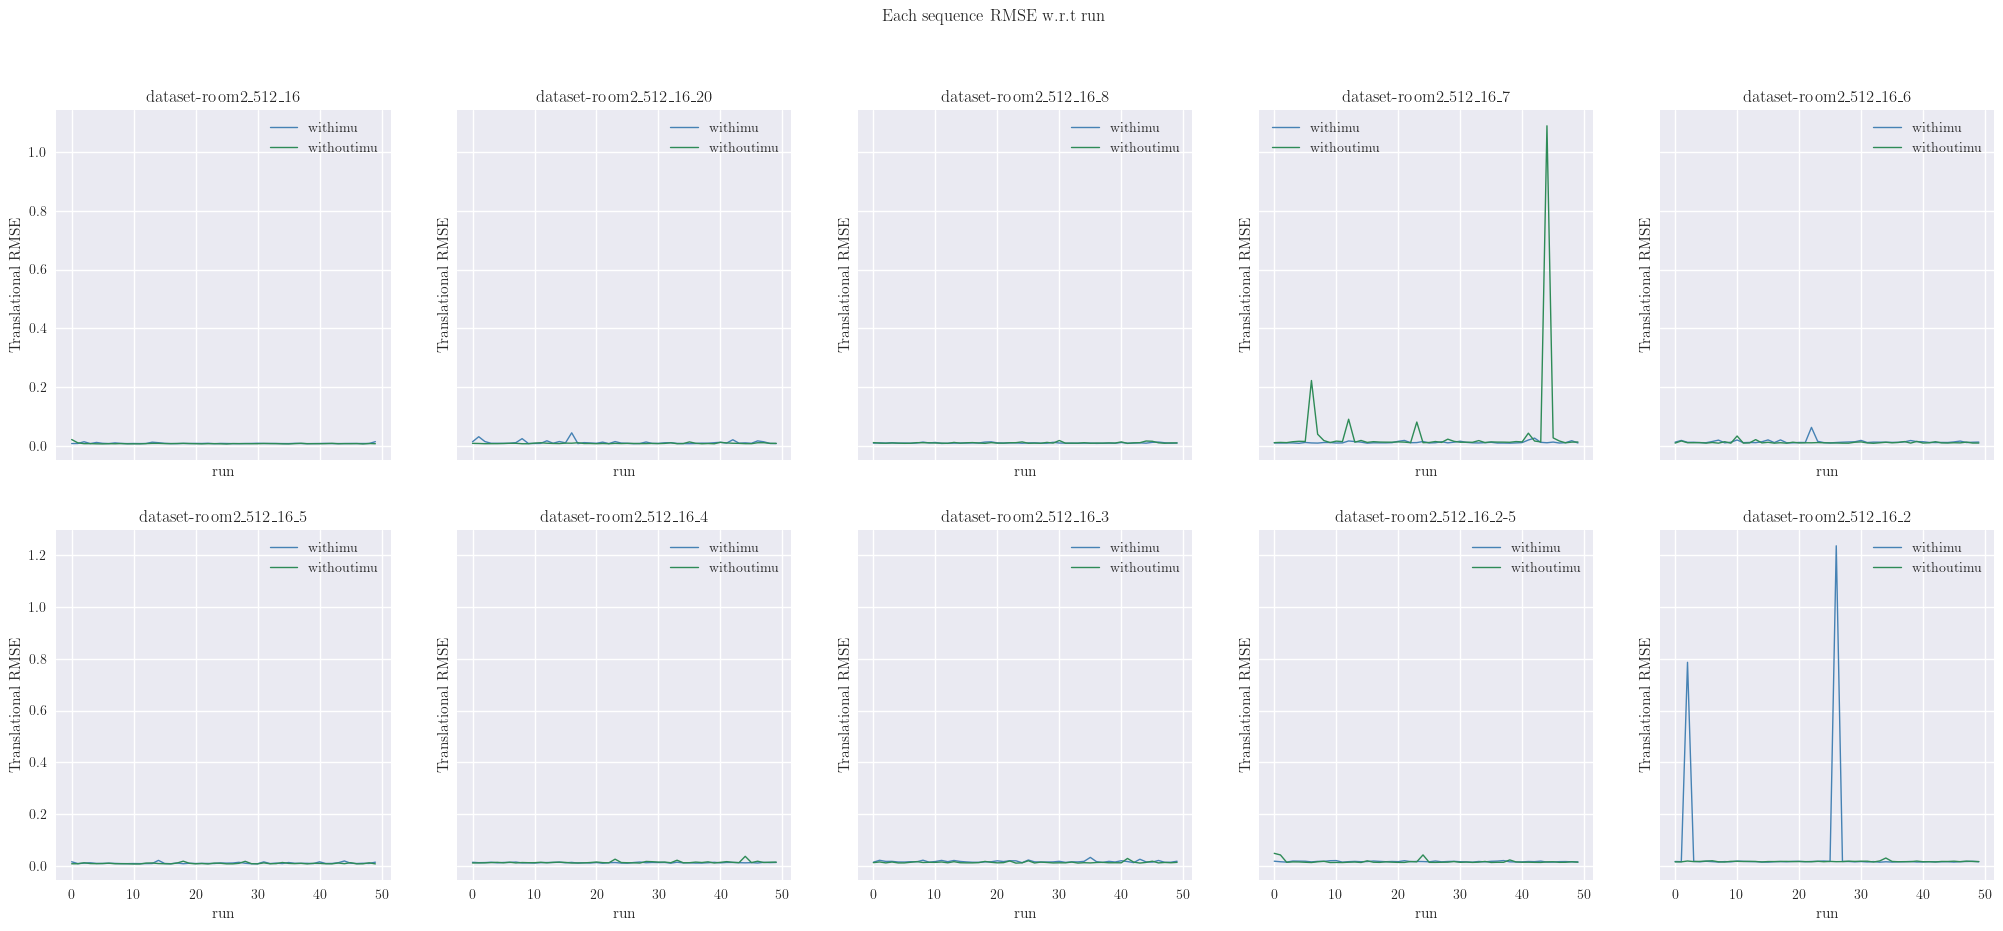

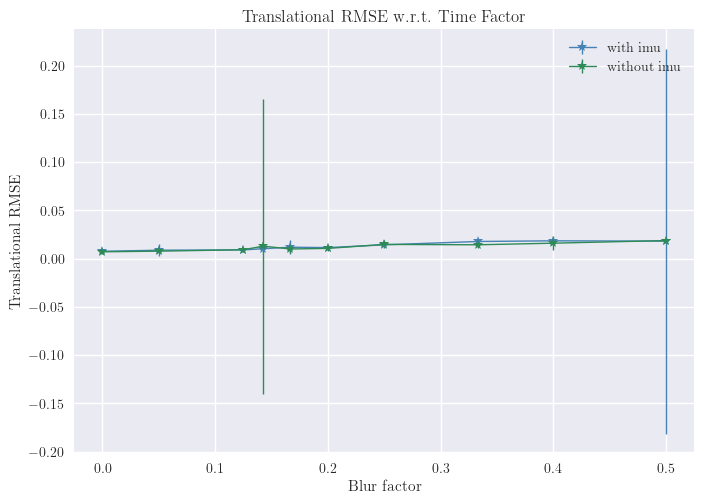

In [15]:
orb_res_t_data2, comp_orb_std_t_data2, comp_orb_tot_t_data2 = compute_results(imu=imu, system=system, sub='/50iterations', datasets=DATASETS_2) 

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_2[count]}')
        axis.plot(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

plt.figure()
plt.errorbar(x, orb_res_t_data2['withimu'], yerr=comp_orb_std_t_data2['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, orb_res_t_data2['withoutimu'], yerr=comp_orb_std_t_data2['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Blur factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()

In [53]:
np.median(comp_orb_tot_t_data2['dataset-room2_512_16withimu'])

0.007439107811268483

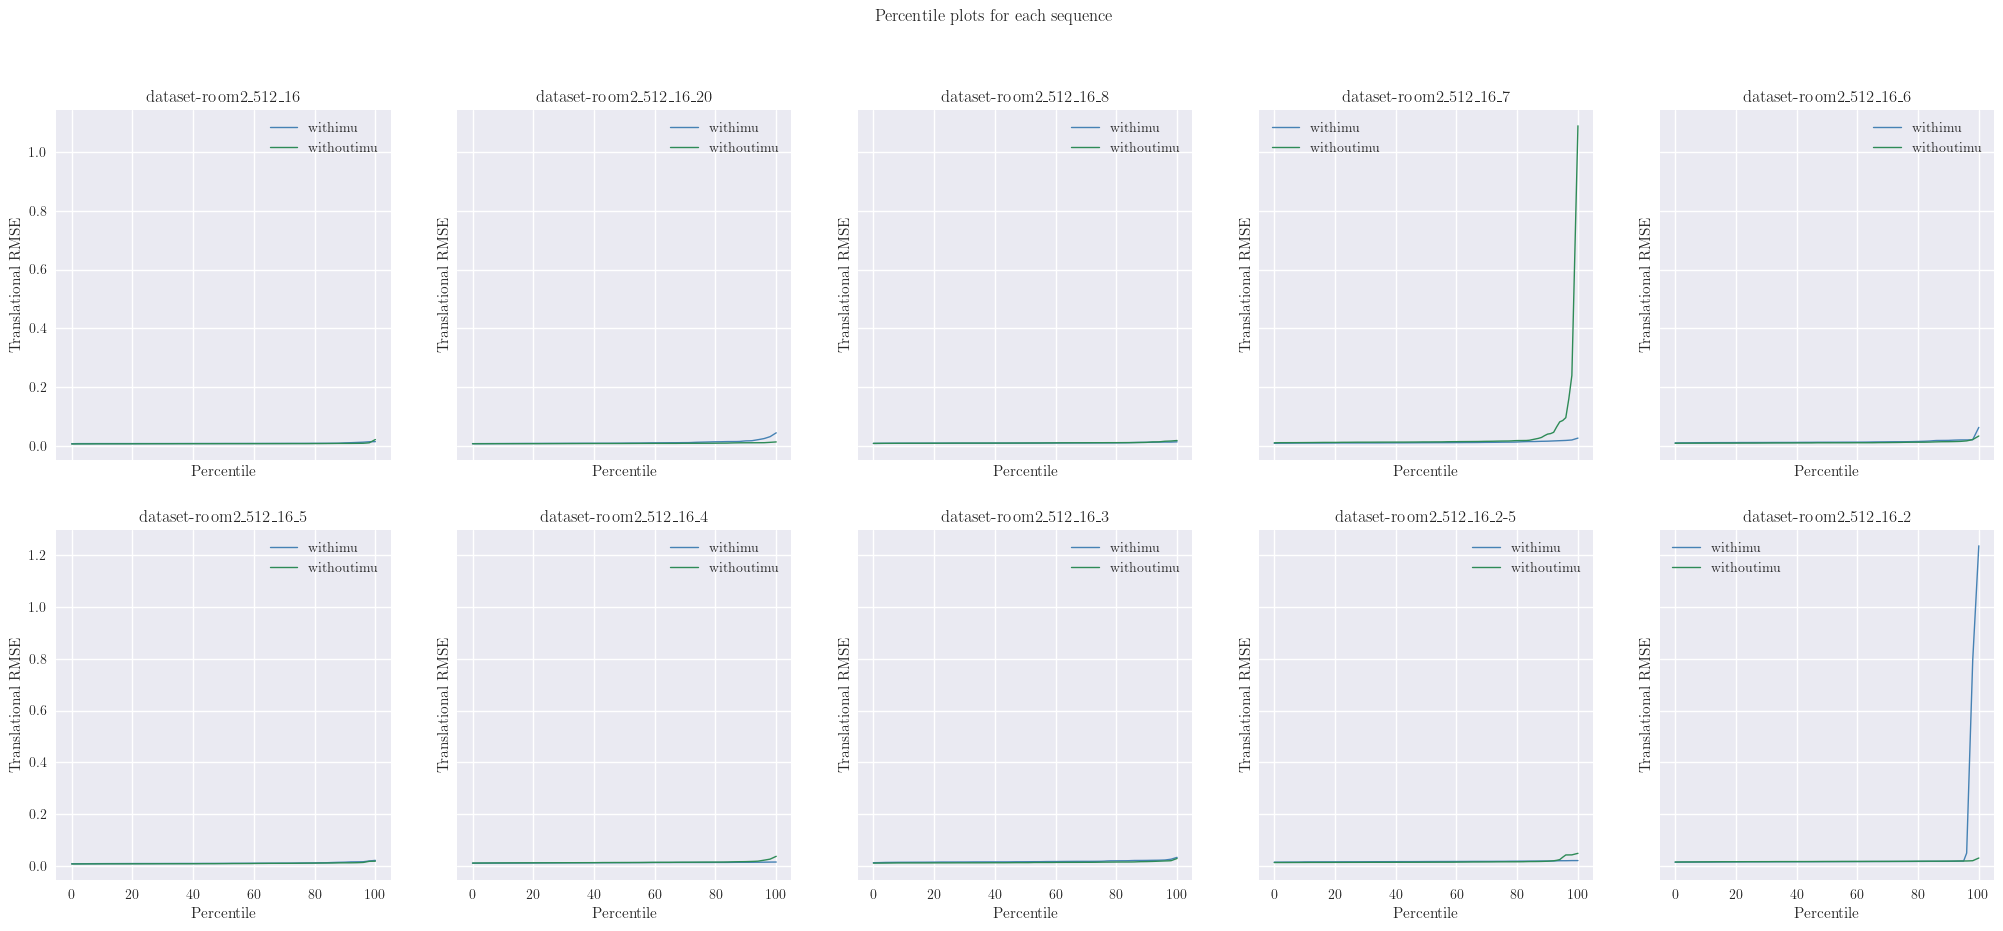

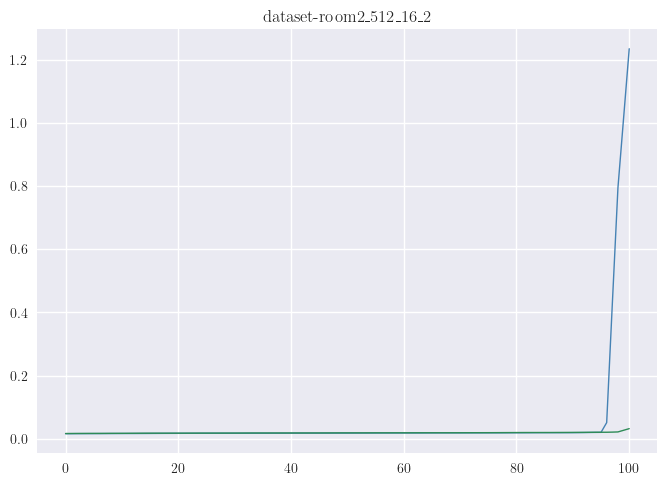

<Figure size 800x550 with 0 Axes>

In [16]:


fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Percentile plots for each sequence')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_2[count]}')
        pctiles_wi = np.percentile(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withimu'], np.arange(0, 101))
        pctiles_woi = np.percentile(comp_orb_tot_t_data2[f'{DATASETS_2[count]}withoutimu'], np.arange(0, 101))
        
        axis.plot(pctiles_wi,  label='withimu', lw=1, color='steelblue')
        axis.plot(pctiles_woi,  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('Percentile') 
        axis.set_ylabel('Translational RMSE')
        
        
        count += 1 

plt.savefig('perc_plot_orbslam.png')


plt.figure()
plt.title('dataset-room2_512_16_2')
pctiles_wi = np.percentile(comp_orb_tot_t_data2[f'dataset-room2_512_16_2withimu'], np.arange(0, 101))
pctiles_woi = np.percentile(comp_orb_tot_t_data2[f'dataset-room2_512_16_2withoutimu'], np.arange(0, 101))
plt.plot(pctiles_wi,  label='withimu', lw=1, color='steelblue')
plt.plot(pctiles_woi,  label='withoutimu', lw=1, color='seagreen')
plt.show()
plt.savefig('blur_2_orbslam.png')

##### Outlier - detection and removal 

In [14]:
np.array(comp_orb_tot_t_data2['dataset-room2_512_16_2withimu'])

array([0.01881599, 0.01805365, 0.02029033, 0.01936641, 0.0183737 ,
       0.01825062, 0.01677354, 0.01636554, 0.01792454, 0.01849748,
       0.017614  , 0.01910017, 0.78577968, 0.01935466, 0.01787933,
       0.01889864, 0.01910692, 0.02058377, 0.01881051, 1.23450511,
       0.01886872, 0.01873677, 0.01744137, 0.01936271, 0.01851414,
       0.01692103, 0.01847645, 0.01606513, 0.01773589, 0.01654804,
       0.01760845, 0.01781264, 0.01871933, 0.01675863, 0.01758697,
       0.01711362, 0.01802883, 0.01723364, 0.01770061, 0.0179916 ,
       0.01645155, 0.01819646, 0.01875694, 0.01938574, 0.01778805,
       0.01977793, 0.01812389, 0.01665759, 0.01838918, 0.01734451])

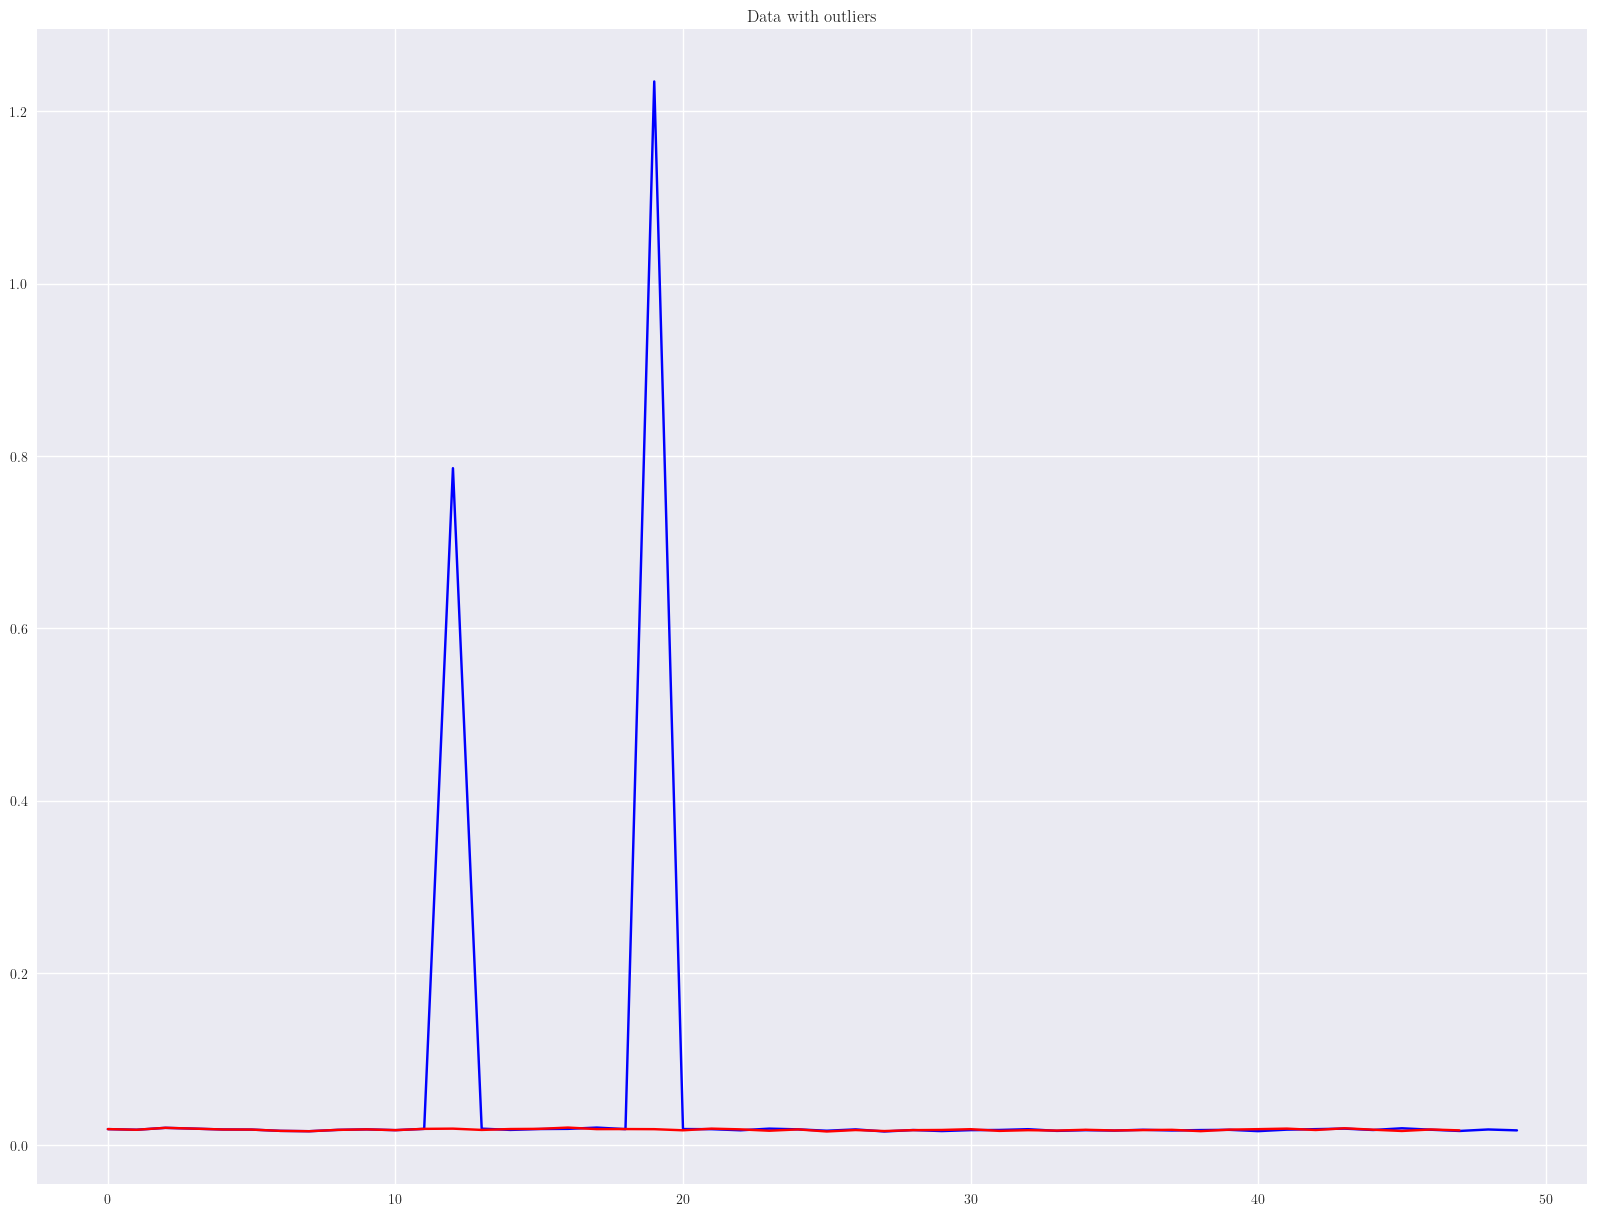

In [15]:
from scipy import stats

data = np.array(comp_orb_tot_t_data2['dataset-room2_512_16_2withimu'])
z_scores = np.abs(stats.zscore(data))
threshold = 3
data_without = data[z_scores<threshold]

plt.figure(figsize=(20,15))

plt.plot(data, color='blue')
plt.plot(data_without, color='red')
plt.title('Data with outliers')


#axs[1].set_title('Data without outliers')

plt.show()

## DM-VIO Analysis 

In [40]:
system = 'dm_vio'
imu = ['withimu', 'withoutimu']

dm_res_t, dm_std_t, dm_tot_t = compute_results(imu=imu, system=system, sub='/photocalib10') 
new_gt_dm_res_t, new_gt_dm_std_t, new_gt_dm_tot_t = compute_results(imu=imu, system=system, sub='/nophotocalib10', datasets=['dataset-room1_512_16']) 
old_gt_dm_res_t, old_gt_dm_std_t, old_gt_dm_tot_t = compute_results(imu=imu, system=system, sub='/nophotocalib10_other_gt', datasets=['dataset-room1_512_16']) 

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']

In [52]:
np.median(dm_tot_t['dataset-room1_512_16withimu'])

0.07640896711931498

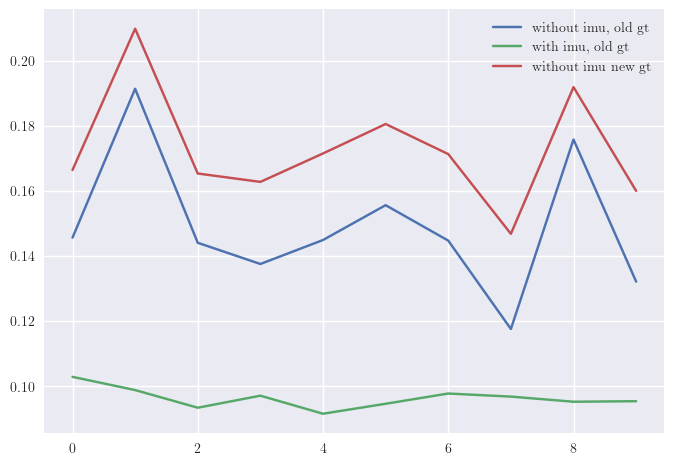

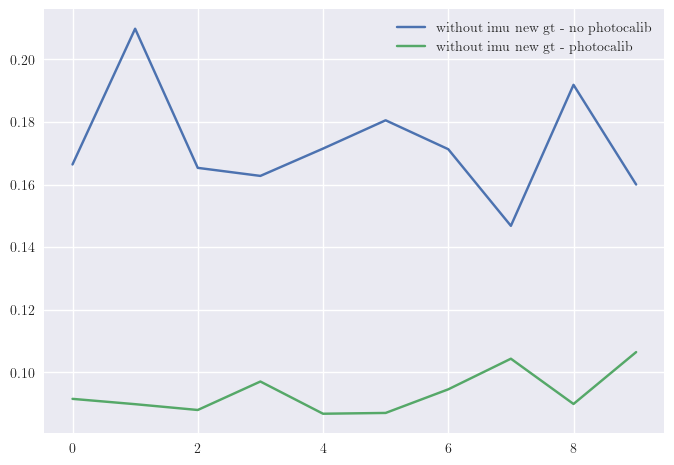

In [62]:
plt.plot(old_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu, old gt') 
plt.plot(old_gt_dm_tot_t['dataset-room1_512_16withimu'], label = 'with imu, old gt') 
plt.plot(new_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt')
plt.legend()
plt.show()

plt.figure()
plt.plot(new_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt - no photocalib')
plt.plot(dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt - photocalib')
plt.legend()
plt.show()

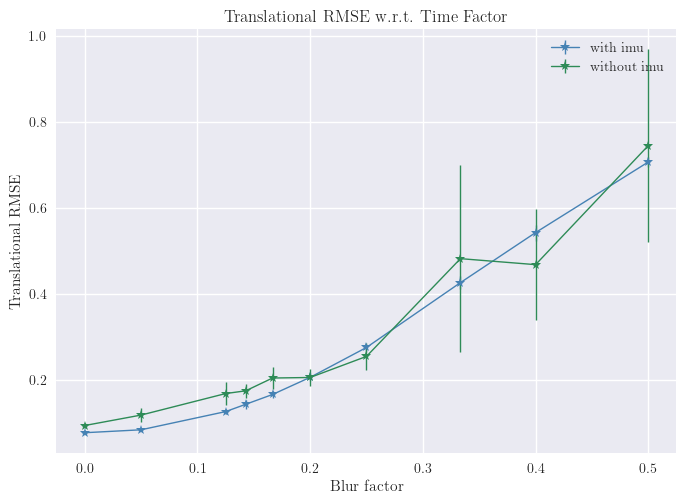

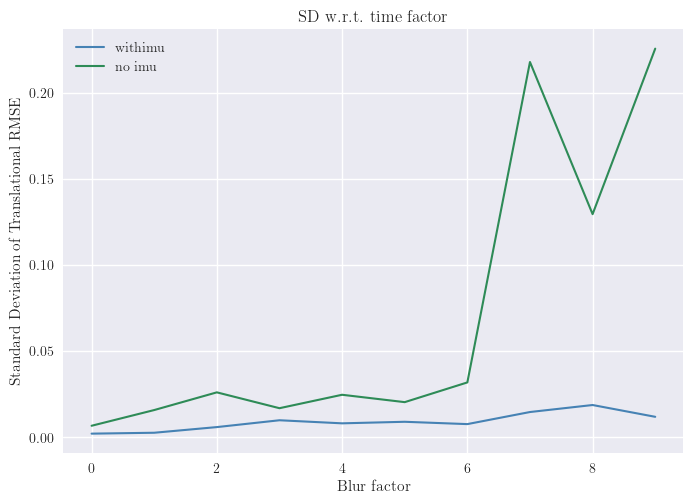

In [63]:
plt.figure()
plt.errorbar(x, dm_res_t['withimu'], yerr=dm_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, dm_res_t['withoutimu'], yerr=dm_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Blur factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()


plt.figure()
plt.plot(dm_std_t['withimu'], label='withimu', lw=1.5, color='steelblue')
plt.plot(dm_std_t['withoutimu'], label='no imu', lw=1.5, color='seagreen')
plt.title('SD w.r.t. time factor')
plt.xlabel('Blur factor')
plt.ylabel('Standard Deviation of Translational RMSE')
plt.legend()
plt.show()

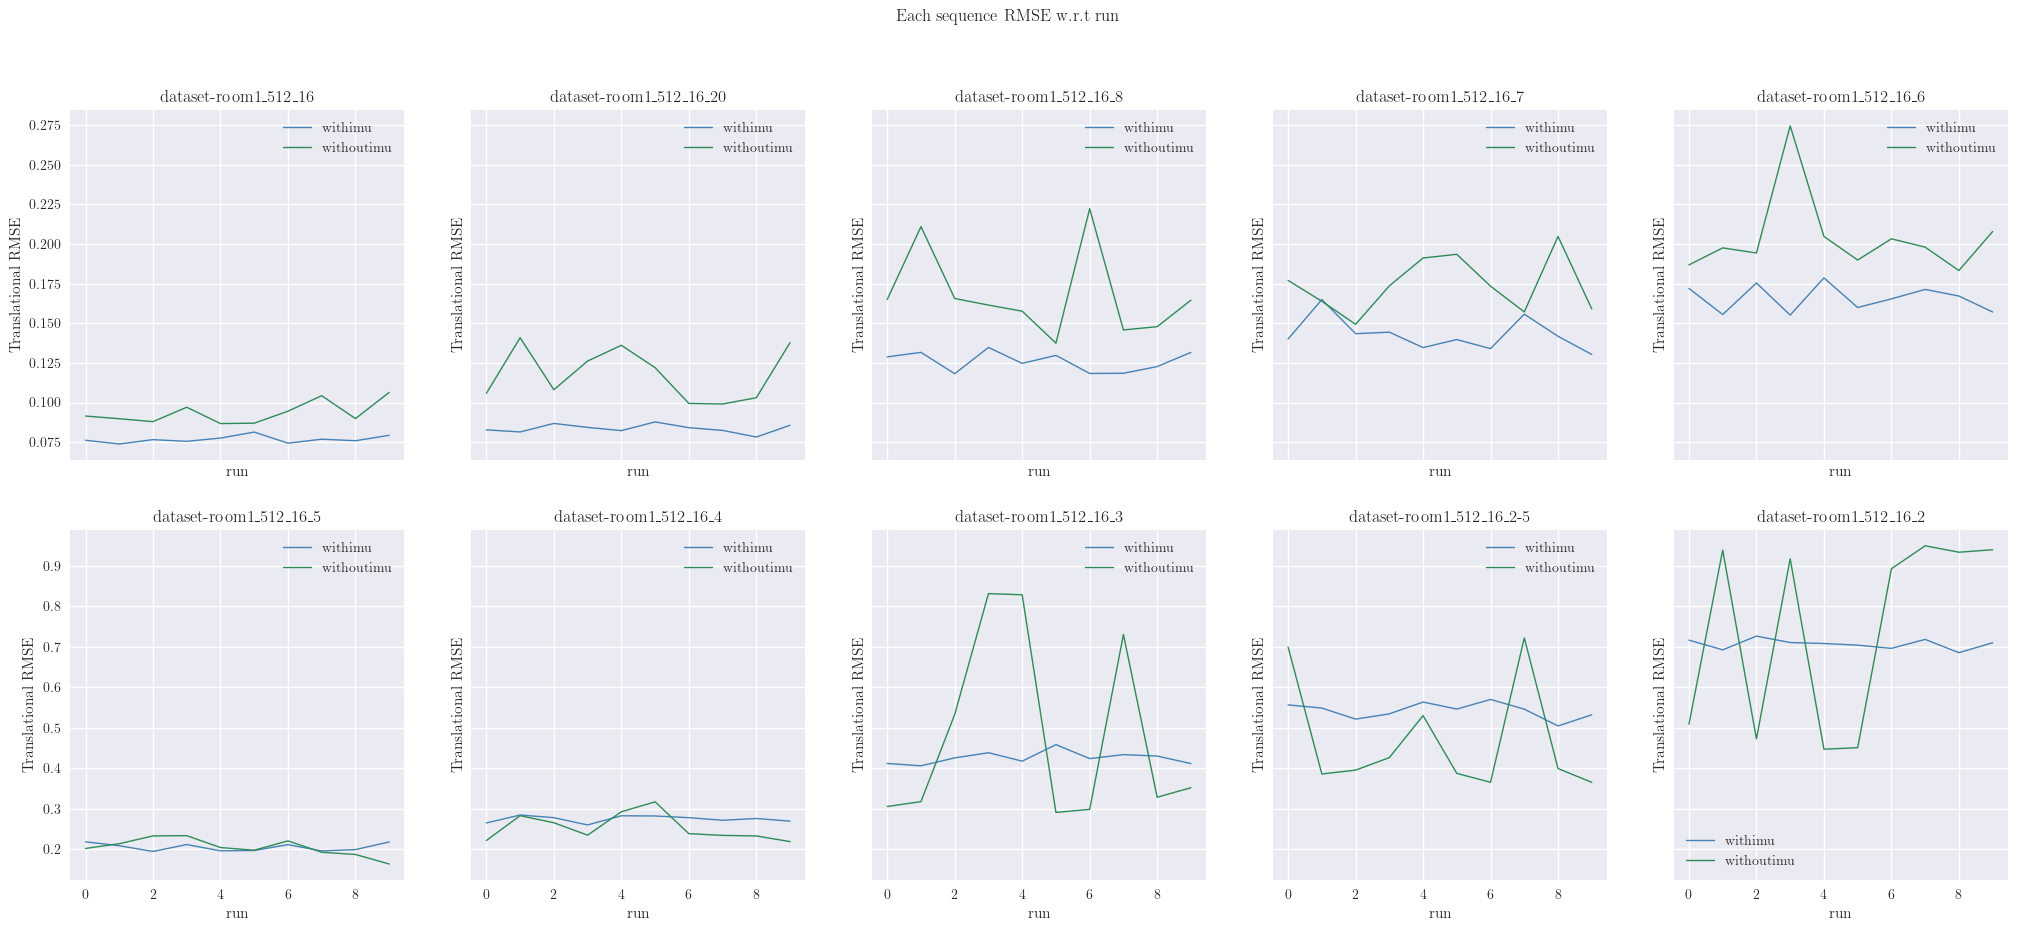

In [64]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS_1[count]}')
        axis.plot(dm_tot_t[f'{DATASETS_1[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(dm_tot_t[f'{DATASETS_1[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

In [65]:
dm_nocalib_res_t, dm_nocalib_std_t, dm_nocalib_tot_t = compute_results(imu=imu, system=system, sub='/nophotocalib10_other_gt') 

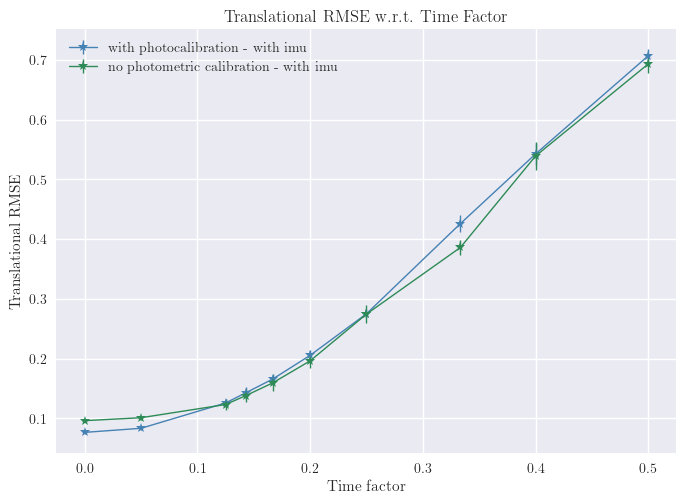

In [66]:
plt.figure()
plt.errorbar(x, dm_res_t['withimu'], yerr=dm_std_t['withimu'], fmt='-*', label='with photocalibration - with imu', lw=1, color='steelblue')
plt.errorbar(x, dm_nocalib_res_t['withimu'], yerr=dm_nocalib_std_t['withimu'], fmt='-*', label='no photometric calibration - with imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()

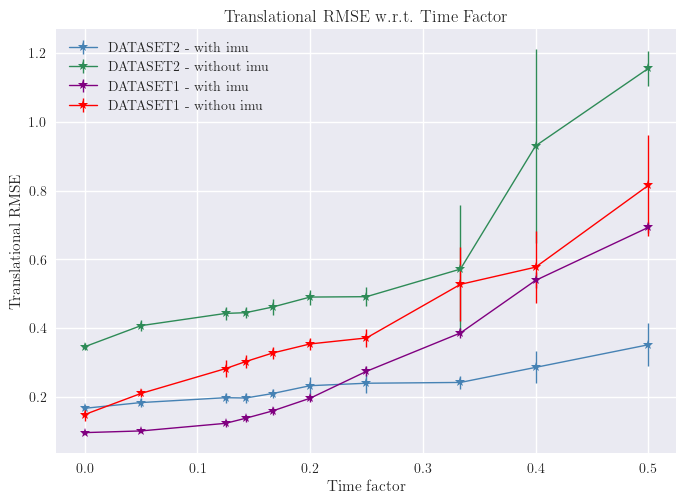

<Figure size 800x550 with 0 Axes>

In [67]:
dm_res_t_data2, dm_std_t_data2, dm_tot_t_data2 = compute_results(imu=imu, system=system, datasets=DATASETS_2)

plt.figure()
plt.errorbar(x, dm_res_t_data2['withimu'], yerr=dm_std_t_data2['withimu'], fmt='-*', label='DATASET2 - with imu', lw=1, color='steelblue')
plt.errorbar(x, dm_res_t_data2['withoutimu'], yerr=dm_std_t_data2['withoutimu'], fmt='-*', label='DATASET2 - without imu',lw=1,color='seagreen')
plt.errorbar(x, dm_nocalib_res_t['withimu'], yerr=dm_nocalib_std_t['withimu'], fmt='-*', label='DATASET1 - with imu',lw=1,color='purple')
plt.errorbar(x, dm_nocalib_res_t['withoutimu'], yerr=dm_nocalib_std_t['withoutimu'], fmt='-*', label='DATASET1 - withou imu',lw=1,color='red')
#plt.errorbar(x, dm_nocalib_res_t['withimu'], yerr=dm_nocalib_std_t['withimu'], fmt='-*', label='noncompensated',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()
plt.savefig('allseqs_dm_vio.png')

In [7]:
x, y, z = compute_results(imu=['withimu', 'withoutimu'], system='dm_vio', datasets=['dataset-room1_512_16'], sub="/50iterations")

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49']
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49']


In [8]:
np.median(z['dataset-room1_512_16withimu'])

0.0943320668796172

## Both 

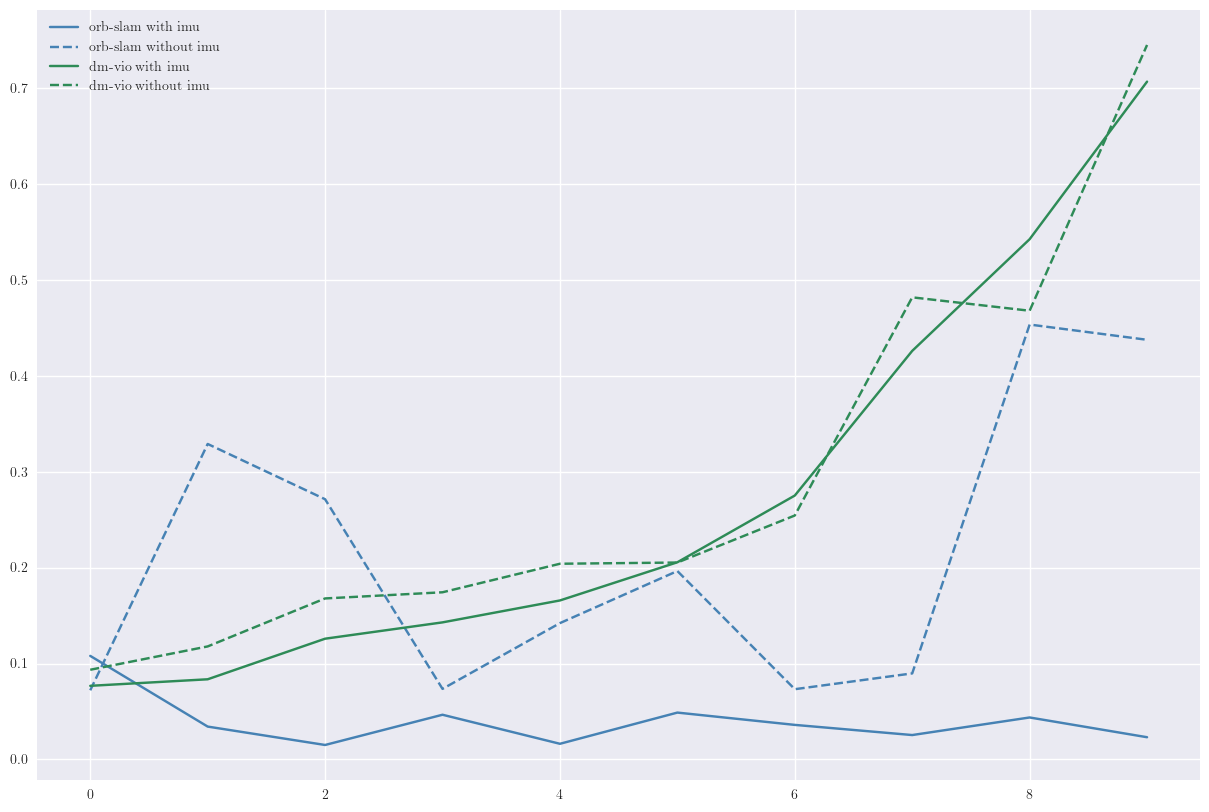

In [ ]:
plt.figure(figsize=(15,10))
# plot_data_fill(comp_orb_res_t['withimu'], comp_orb_std_t['withimu'], x, 'withimu')
# plot_data_fill(comp_orb_res_t['withoutimu'], comp_orb_std_t['withoutimu'], x, 'withoutimu')
# plot_data_fill(dm_res_t['withimu'], dm_std_t['withimu'], x, 'withimu')
# plot_data_fill(dm_res_t['withoutimu'], dm_std_t['withoutimu'], x, 'withoutimu')
plt.plot(comp_orb_res_t['withimu'], label='orb-slam with imu', color='steelblue')
plt.plot(comp_orb_res_t['withoutimu'], ls='--', label='orb-slam without imu', color='steelblue')
plt.plot(dm_res_t['withimu'], label='dm-vio with imu', color='seagreen')
plt.plot(dm_res_t['withoutimu'], ls='--', label='dm-vio without imu', color='seagreen')
plt.legend()
plt.show()